In [46]:
!pip install pymc
!pip install numpy
!pip install "pymc>=5.0.0" "scipy>=1.10.0"
!pip install networkx

import numpy as np
import pymc as pm

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import networkx as nx

Define alpha_j as a random variable for each j, it's a graded score showing the preference for each subject

In [28]:

# Assuming M latent vectors, each of length K
M = 10
K = 5
Sigma_rho = 0.95

# Create a diagonal covariance matrix
covariance_matrix = np.eye(K) * Sigma_rho


Covariate Notation:

Let’s assume there are 𝐾 covariates. X is now an 𝑀×𝐾 matrix, where:
- X: The design matrix has 𝑀 items and 
- K covariates.
- 𝛽: A 𝐾×1 vector of coefficients that relates the covariates to the outcome.
The covariate contribution 𝛼 is computed as: 𝛼= Xβ
- α is an 𝑀 × 1 vector, representing the effect of covariates on each item.
- The expression 𝛼⋅1𝐾𝑇 is intended to replicate the effect of 𝛼 across all 𝐾 dimensions.


Transformation with CDF (Φ) and Inverse CDF G to the interval [0, 1]. 𝐺 inverse function is the inverse CDF (quantile function) of another distribution (likely Gumbel). 


The theorem states that ℎ(𝜂:,𝑘) after applying ℎ, follows a probability law 𝑃𝐿(𝛼;𝑀) for each k

In [37]:
import pytensor.tensor as at
from scipy.stats import norm
# Define the PyMC model context

X = np.random.normal(size=(M, K))
 # Step 1: Define the latent variable U as an MvNormal distribution
U = multivariate_normal.rvs(mean=np.zeros(K), cov=covariance_matrix, size=M)  # Shape (M, K)

# Step 2: Apply the transformation to get correlated uniform random variables
Phi_U = norm.cdf(U)  # Equivalent to applying the CDF of a standard normal to U

# Step 3: Apply the Gumbel inverse CDF (G^-1)
G_inv_Phi_U = -np.log(-np.log(Phi_U))

# Step 4: Define the covariate effect with a linear relationship
beta = np.random.normal(0, 1, size=(K,))  # Sample beta from a normal distribution
alpha = np.dot(X, beta)  # Shape (M,)

# Step 5: Compute eta, including latent variable U and covariate effects
eta = G_inv_Phi_U + alpha[:, None]  # Broadcasting alpha to match shape (M, K)

# Step 6: Define the Plackett-Luce distribution for ranking the items
# Using a softmax to convert eta to selection probabilities
ranking_probs = np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True)

# Step 7: Define observed rankings (for demonstration purposes)
observed_rankings = np.arange(M)  # Example observed rankings from 0 to M-1 



# Print Phi_U for inspection
print("Phi_U values:\n", Phi_U)

# Step 8: Simulate sampling from the posterior
# For demonstration, we'll generate samples of U and beta
num_samples = 1000
U_samples = [multivariate_normal.rvs(mean=np.zeros(K), cov=covariance_matrix, size=M) for _ in range(num_samples)]
beta_samples = [np.random.normal(0, 1, size=(K,)) for _ in range(num_samples)]

# Compute eta and ranking_probs using the sampled values
eta_values = [-np.log(-np.log(0.5 * (1 + norm.cdf(U_sample / np.sqrt(2))))) + np.dot(X, beta_sample)[:, None]
              for U_sample, beta_sample in zip(U_samples, beta_samples)]
ranking_probs_values = [np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True) for eta in eta_values]



Phi_U values:
 [[0.9804741  0.1348095  0.7678851  0.61531228 0.91909271]
 [0.07791133 0.24693388 0.17941886 0.47246714 0.09474462]
 [0.71175142 0.46801153 0.1340849  0.94862152 0.71740973]
 [0.974051   0.15806918 0.222735   0.54337259 0.69802481]
 [0.51734527 0.43045419 0.91276409 0.22087604 0.05837196]
 [0.55831597 0.29334414 0.18335495 0.37900495 0.83808781]
 [0.1785636  0.18135513 0.45517992 0.3702559  0.03616671]
 [0.06106949 0.94127749 0.5506341  0.63073485 0.1182747 ]
 [0.10334499 0.20282947 0.64194486 0.69400596 0.9052344 ]
 [0.04954144 0.82155781 0.57310049 0.57800831 0.0493469 ]]


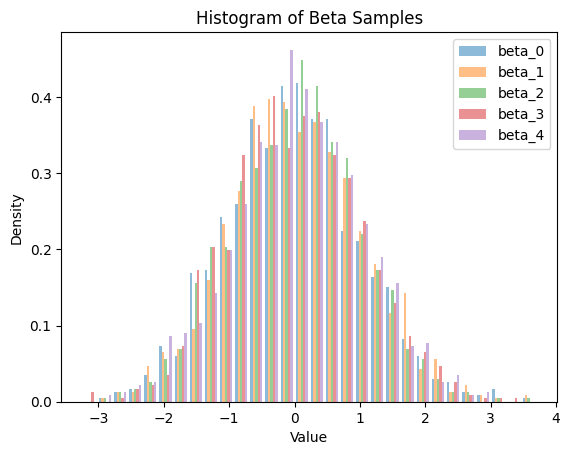

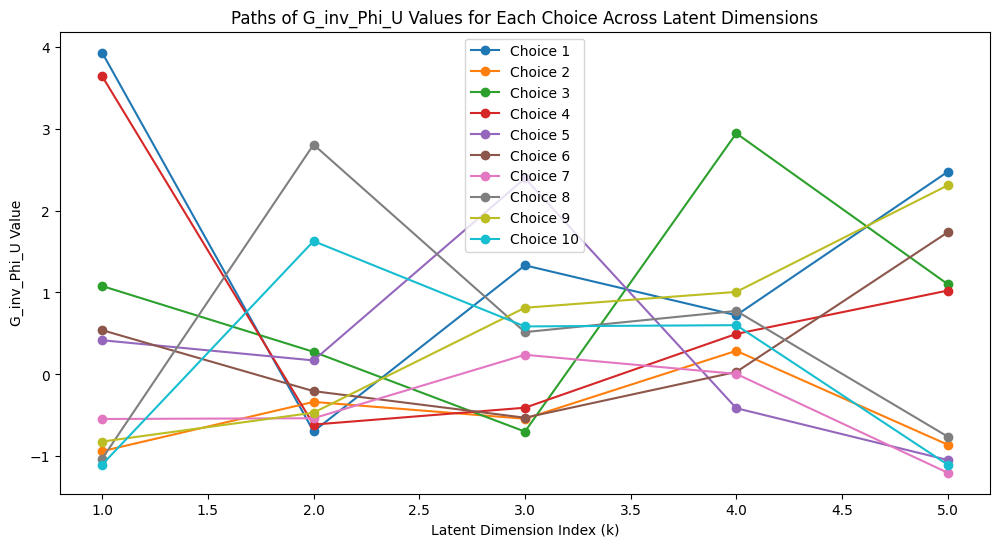

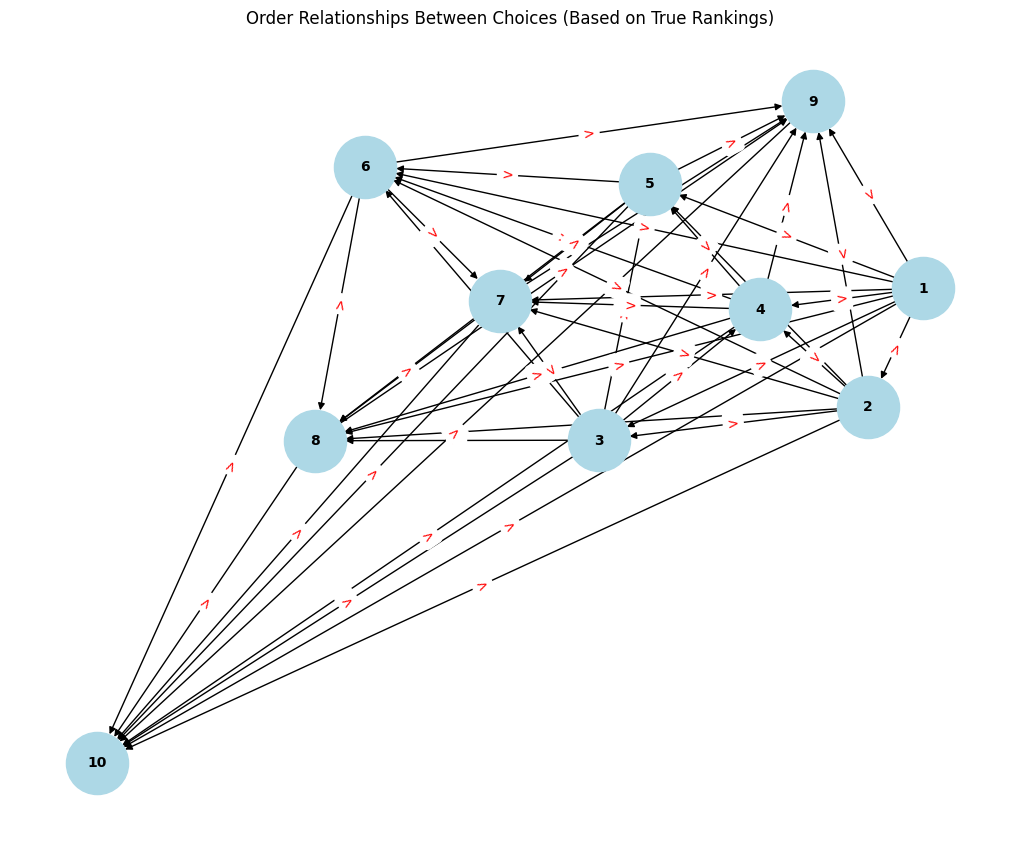

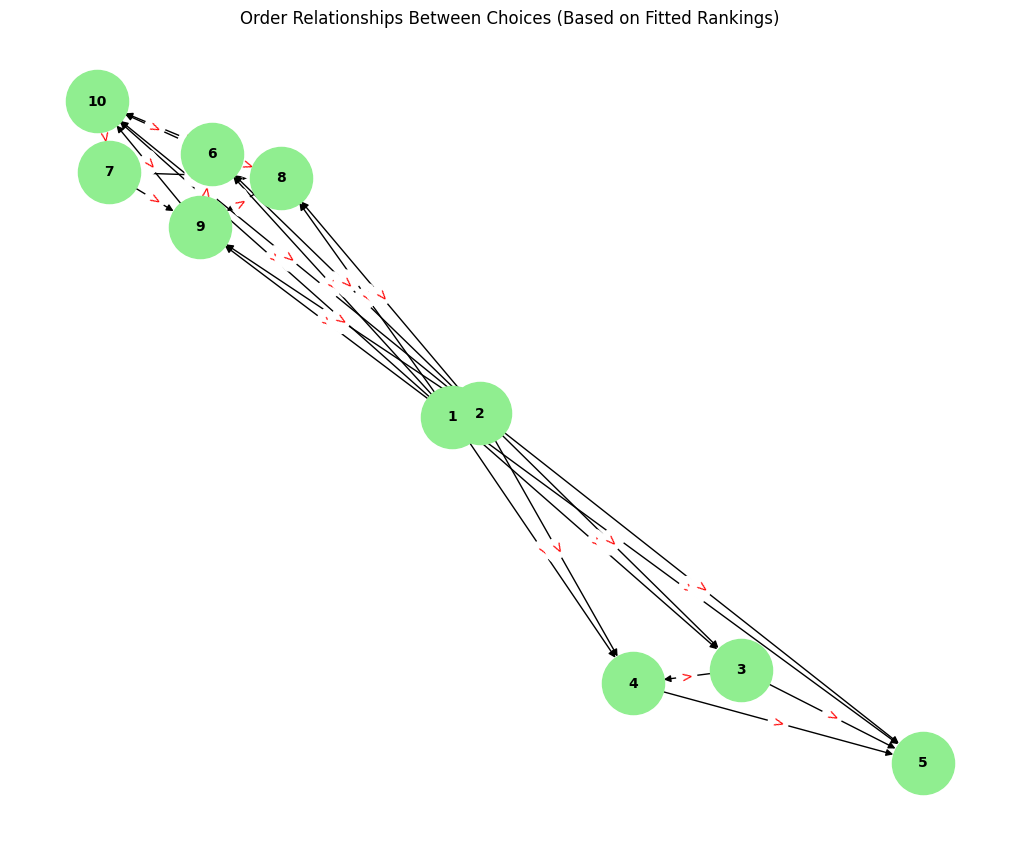

In [45]:

# Plot histogram of beta samples
beta_samples_array = np.array(beta_samples)
plt.hist(beta_samples_array, bins=30, density=True, alpha=0.5, label=[f'beta_{i}' for i in range(K)])
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Beta Samples')
plt.show()


# Plot G_inv_Phi_U paths for each item
plt.figure(figsize=(12, 6))
for j in range(M):
    plt.plot(range(1, K + 1), G_inv_Phi_U[j, :], marker='o', linestyle='-', label=f'Choice {j + 1}')
plt.xlabel('Latent Dimension Index (k)')
plt.ylabel('G_inv_Phi_U Value')
plt.title('Paths of G_inv_Phi_U Values for Each Choice Across Latent Dimensions')
plt.legend()
plt.show()


# Plot order relationships using a directed graph based on true observed rankings
G = nx.DiGraph()


# Add nodes for each item
for i in range(M):
    G.add_node(i + 1, label=f'Choice {i + 1}')

# Add edges based on observed rankings
for i in range(M):
    for j in range(i + 1, M):
        if observed_rankings[i] < observed_rankings[j]:
            G.add_edge(observed_rankings[i] + 1, observed_rankings[j] + 1)  # i ranks higher than j

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): '>' for u, v in G.edges()}, font_color='red')
plt.title('Order Relationships Between Choices (Based on True Rankings)')
plt.show()


# Plot order relationships using a directed graph based on fitted rankings (ranking_probs)
G_fitted = nx.DiGraph()

# Add nodes for each item
for i in range(M):
    G_fitted.add_node(i + 1, label=f'Choice {i + 1}')

# Determine fitted rankings based on ranking probabilities
fitted_rankings = np.argsort(-np.sum(ranking_probs, axis=1))  # Rank items based on their total ranking probabilities (descending order)

# Add edges based on fitted rankings
for i in range(M):
    for j in range(i + 1, M):
        if fitted_rankings[i] < fitted_rankings[j]:
            G_fitted.add_edge(fitted_rankings[i] + 1, fitted_rankings[j] + 1)  # i ranks higher than j

# Draw the fitted ranking graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_fitted)
nx.draw(G_fitted, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightgreen', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G_fitted, pos, edge_labels={(u, v): '>' for u, v in G_fitted.edges()}, font_color='red')
plt.title('Order Relationships Between Choices (Based on Fitted Rankings)')
plt.show()